# Week 7 - Vector Space Word Embeddings

This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them. Documents here are represented as densely indexed locations in dimensions, rather than sparse mixtures of topics (as in LDA topic modeling), so that distances between those documents (and words) are consistently superior, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

For this notebook we will be using the following packages

In [2]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

C:\Users\acmel\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using at least two different specification of `word2vec`, and visualize them each with two separate visualization layout specifications (e.g., TSNE, PCA). Then interrogate critical word vectors within your corpus in terms of the most similar words, analogies, and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the semantic organization of words in your corpora? Which estimation and visualization specification generate the most insight and appear the most robustly supported and why? 

<span style="color:red">***Stretch***: Explore different vector calculations beyond addition and subtraction, such as multiplication, division or some other function. What does this exploration reveal about the semantic structure of your corpus?

The corpora for this assignment and the accompanying presentation was built from the most recent 2-10 HITs published first 10 Requesters who appeared on the first 2 pages of the mTurk HITs page at 6:13pm 2/20/2020 and had published 2 or more HITs at that point in time.

In [3]:
def loadDir(targetDir, category):
    allFileNames = os.listdir(targetDir)
    #We need to make them into useable paths and filter out hidden files
    filePaths = [os.path.join(targetDir, fname) for fname in allFileNames if fname[0] != '.']

    #The dict that will become the DataFrame
    hitsDict = {
        'Requester' : [category] * len(filePaths),
        'filePath' : [],
        'text' : [],
    }

    for fPath in filePaths:
        with open(fPath) as f:
            hitsDict['text'].append(f.read())
            hitsDict['filePath'].append(fPath)

    return pandas.DataFrame(hitsDict)

In [4]:
dataDir = r'C:\Users\acmel\OneDrive - The University of Chicago\SOCI 40133\CorporaV1'

hitsDF = pandas.DataFrame()

for reqName in [d for d in os.listdir(dataDir) if d[0] != '.']:
    reqPath = os.path.join(dataDir, reqName)
    hitsDF = hitsDF.append(loadDir(reqPath, reqName), ignore_index = True)

hitsDF[:100:1]

,Requester,filePath,text
0,Bailey OSullivan,C:\Users\acmel\OneDrive - The University of Ch...,"Bailey O'Sullivan\nContact Info Search\n1,360\..."
1,Bailey OSullivan,C:\Users\acmel\OneDrive - The University of Ch...,Bailey O'Sullivan\nContact Info Search\n303\n$...
2,Bailey OSullivan,C:\Users\acmel\OneDrive - The University of Ch...,\nBailey O'Sullivan\nContact Info Search\n9\n$...
3,Content Research,C:\Users\acmel\OneDrive - The University of Ch...,Content Research\nClean Up How-To Questions\n4...
4,Content Research,C:\Users\acmel\OneDrive - The University of Ch...,Content Research\nCategorize User Reviews\n1\n...
5,HYUNSUK CHUNG,C:\Users\acmel\OneDrive - The University of Ch...,HYUNSUK CHUNG\nWrite the words shown in an ima...
6,HYUNSUK CHUNG,C:\Users\acmel\OneDrive - The University of Ch...,\nHYUNSUK CHUNG\nWrite the words shown in an i...
7,Jesse D Crosson,C:\Users\acmel\OneDrive - The University of Ch...,Jesse D. Crosson\nCongressional press release ...
8,Jesse D Crosson,C:\Users\acmel\OneDrive - The University of Ch...,Jesse D. Crosson\nCongressional press release ...
9,Jiaxin,C:\Users\acmel\OneDrive - The University of Ch...,Jiaxin\nDo these two questions have the same m...


In [19]:
#Apply our functions, notice each row is a list of lists now
hitsDF['tokenized_sents'] = hitsDF['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
hitsDF['normalized_sents'] = hitsDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])

hitsDF[:100:10]

,Requester,filePath,text,tokenized_sents,normalized_sents
0,Bailey OSullivan,C:\Users\acmel\OneDrive - The University of Ch...,"Bailey O'Sullivan\nContact Info Search\n1,360\...","[[Bailey, O'Sullivan], [Contact, Info, Search]...","[[bailey, o'sullivan], [contact, info, search]..."
10,Jiaxin,C:\Users\acmel\OneDrive - The University of Ch...,Jiaxin\nParaphrase machine-generated questions...,"[[Jiaxin], [Paraphrase, machine, generated, qu...","[[jiaxin], [paraphrase, machine, generated, qu..."
20,Panel,C:\Users\acmel\OneDrive - The University of Ch...,Panel\nExtract purchased items from a shopping...,"[[Panel, Extract, purchased, items, from, a, s...","[[panel, extract, purchased, items, shopping, ..."
30,Shopping Receipts,C:\Users\acmel\OneDrive - The University of Ch...,Shopping Receipts\nExtract Data From Shopping ...,"[[Shopping, Receipts, Extract, Data, From, Sho...","[[shopping, receipts, extract, data, shopping,..."


Word2Vec: Specification 1

In [20]:
hitsW2V = gensim.models.word2vec.Word2Vec(hitsDF['normalized_sents'].sum())

In [21]:
hitsW2V['image']

array([ 0.00122388, -0.00076725, -0.00295147, -0.00222785, -0.0002418 ,
        0.00231489, -0.0033321 , -0.00059896,  0.00055431, -0.00119273,
       -0.00143104, -0.00219576,  0.0037958 ,  0.0006212 ,  0.00051404,
       -0.00245903, -0.00095354, -0.00178825,  0.00387847, -0.00012808,
        0.00031287, -0.00210633,  0.00243312,  0.00151135, -0.00468423,
       -0.00406093,  0.00019838,  0.00091792, -0.00408264,  0.00031891,
       -0.00244472,  0.00209078, -0.00299991, -0.00043911, -0.00157594,
        0.0038874 , -0.00321894,  0.00232372,  0.0047093 , -0.00061913,
        0.00124844, -0.0023207 , -0.00483933,  0.003527  ,  0.00490445,
       -0.00225551,  0.00456187,  0.00019545, -0.00267284, -0.00244363,
       -0.00449666, -0.00092248, -0.00111425, -0.00465863,  0.00021814,
       -0.00335214, -0.00232724,  0.00111041,  0.00369203, -0.00107501,
       -0.00358381, -0.00403096, -0.00024809, -0.00037848,  0.00221302,
       -0.00088916, -0.00096496, -0.00198551, -0.00327982, -0.00

In [17]:
hitsW2V.wv.syn0

array([[-4.9426293e-05,  2.8669080e-03, -2.6212606e-04, ...,
         1.1629476e-03, -1.6497442e-03,  1.2856591e-03],
       [-4.5491555e-03, -2.0386593e-03, -1.5265390e-03, ...,
        -4.7021676e-03, -3.2747334e-03, -2.5140147e-03],
       [-3.7724117e-03, -6.6626648e-04, -8.0005254e-04, ...,
         4.3791762e-04, -4.1752076e-03,  2.6993128e-03],
       ...,
       [-1.4074030e-03,  1.7413161e-03, -1.3946781e-04, ...,
        -1.7826034e-04, -8.9883571e-04, -1.9014614e-03],
       [-4.2812852e-03,  9.3821052e-04,  2.3860224e-03, ...,
        -1.5778609e-03,  2.7265822e-04,  4.7653541e-03],
       [-7.8760425e-04,  3.7690669e-03, -4.5359894e-03, ...,
        -3.6959960e-03,  2.8811026e-04, -2.2109712e-03]], dtype=float32)

In [24]:
hitsW2V.wv.index2word

['shopping',
 'receipt',
 '$',
 'preview',
 'description',
 'time',
 'allotted',
 'min',
 'ago',
 'extract',
 'items',
 'qualify',
 'image',
 'data',
 'purchased',
 'write',
 'panel',
 'receipts',
 'readable',
 'quantities',
 'blackened',
 'm',
 'transcribe',
 'words',
 'question',
 'story',
 'contact',
 'info',
 'find',
 'email',
 'questions',
 'amounts',
 'grocery',
 'table',
 'item']

In [23]:
hitsW2V.most_similar('image')

[('write', 0.201379656791687),
 ('quantities', 0.19973474740982056),
 ('email', 0.19581639766693115),
 ('readable', 0.1642829179763794),
 ('table', 0.14689227938652039),
 ('$', 0.13983969390392303),
 ('item', 0.13023696839809418),
 ('data', 0.12102698534727097),
 ('shopping', 0.11356722563505173),
 ('receipt', 0.11013369262218475)]

In [13]:
hitsW2V.most_similar('find')

[('shopping', 0.20909033715724945),
 ('$', 0.19313885271549225),
 ('receipts', 0.135716050863266),
 ('allotted', 0.12712305784225464),
 ('table', 0.11834673583507538),
 ('m', 0.11162528395652771),
 ('questions', 0.10646998882293701),
 ('transcribe', 0.10446959733963013),
 ('quantities', 0.08347540348768234),
 ('write', 0.07331213355064392)]

In [14]:
hitsW2V.most_similar('transcribe')

[('min', 0.21765218675136566),
 ('allotted', 0.11665596812963486),
 ('words', 0.11570071429014206),
 ('time', 0.10167400538921356),
 ('info', 0.08545220643281937),
 ('find', 0.05904669314622879),
 ('questions', 0.05738586187362671),
 ('receipt', 0.04963168874382973),
 ('table', 0.029987188056111336),
 ('blackened', 0.025657443329691887)]

In [15]:
hitsW2V.most_similar('words')

[('time', 0.26957374811172485),
 ('purchased', 0.1534736156463623),
 ('story', 0.150374636054039),
 ('transcribe', 0.11570071429014206),
 ('items', 0.031563445925712585),
 ('shopping', 0.018973156809806824),
 ('write', 0.018951203674077988),
 ('question', 0.012121289037168026),
 ('item', 0.0026301294565200806),
 ('image', 0.001462545245885849)]

In [16]:
hitsW2V.most_similar(
    positive=['image','find'], 
    negative=['transcribe','words']
)

[('extract', 0.18462009727954865),
 ('m', 0.1431097388267517),
 ('contact', 0.13562709093093872),
 ('question', 0.1350313425064087),
 ('amounts', 0.13064219057559967),
 ('email', 0.11675072461366653),
 ('panel', 0.10065481066703796),
 ('qualify', 0.09521669149398804),
 ('min', 0.0948956087231636),
 ('data', 0.09396128356456757)]

These words (W) are the best results for the semantic equation of X+Y-Z=W where X=image and Z=transcribe+words.  The purpose of this test is to attempt an analysis of which terms appear most frequently in HITs assigned for the processing of image data but which do not involve the transcription of written words.  Hypothetically, given what is known about the types of HIT work involving image analysis generally exist, we can infer that words (W) are those which are most frequently associated with HITs assigned for the purpose of training image-based ML as opposed to those for transcribing scanned texts -- another common form of image-based HIT.  

That said, the coefficients which appear here are small, indicating that there might not be a strong distinction between these two hypothetical categories of HITs as represented in the dataset.

In [17]:
hitsW2V.save("hitsWord2Vec")


C:\Users\acmel\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [18]:
numWords = 50
targetWords = hitsW2V.wv.index2word[:numWords]


In [19]:
wordsSubMatrix = []
for words in targetWords:
    wordsSubMatrix.append(hitsW2V['image'])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[ 3.8494461e-03,  4.6031359e-03, -1.8997438e-05, ...,
        -4.5799920e-03,  3.4788849e-03, -8.7088667e-04],
       [ 3.8494461e-03,  4.6031359e-03, -1.8997438e-05, ...,
        -4.5799920e-03,  3.4788849e-03, -8.7088667e-04],
       [ 3.8494461e-03,  4.6031359e-03, -1.8997438e-05, ...,
        -4.5799920e-03,  3.4788849e-03, -8.7088667e-04],
       ...,
       [ 3.8494461e-03,  4.6031359e-03, -1.8997438e-05, ...,
        -4.5799920e-03,  3.4788849e-03, -8.7088667e-04],
       [ 3.8494461e-03,  4.6031359e-03, -1.8997438e-05, ...,
        -4.5799920e-03,  3.4788849e-03, -8.7088667e-04],
       [ 3.8494461e-03,  4.6031359e-03, -1.8997438e-05, ...,
        -4.5799920e-03,  3.4788849e-03, -8.7088667e-04]], dtype=float32)

PCA

In [20]:
pcaWords = sklearn.decomposition.PCA(n_components = 10).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

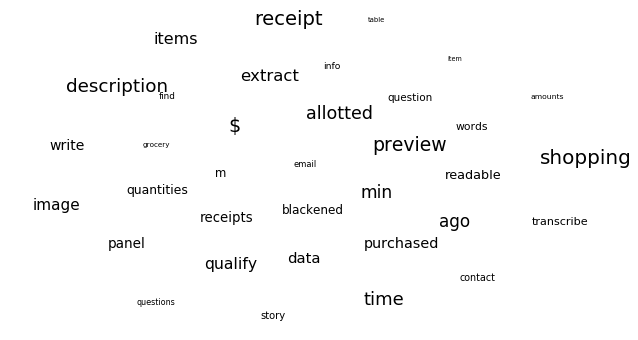

In [21]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

The word cloud validates to a certain extent the previously mentioned hypothesis that HITs which involve "image[s]" are associated with both "words" and "find" -- implying that there are multiple types of analysis being performed involving either scanned writing or visual objects.  However, the distance of "transcribe" from "image" here discounts that hypothesis somewhat, despite other word-associated terms like "receipt" and "readable" remaining relative close to it.

Spectral Embedding

In [106]:
SpectralEmbeddingWords = sklearn.manifold.SpectralEmbedding(n_components = 2).fit_transform(reducedPCA_data)

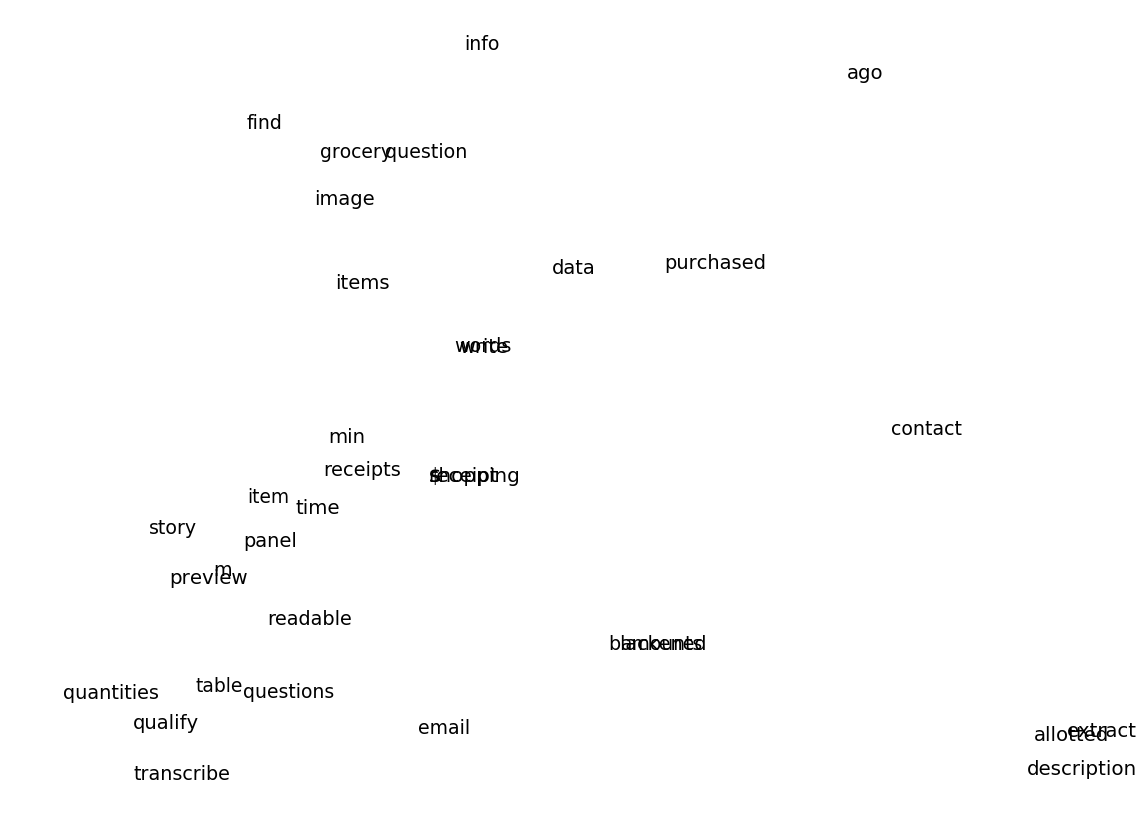

In [107]:
fig = plt.figure(figsize = (20, 15))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(SpectralEmbeddingWords[:, 0], SpectralEmbeddingWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (SpectralEmbeddingWords[:, 0][i],SpectralEmbeddingWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

Word2Vec: Specification 2

In [27]:
hits2W2V = gensim.models.word2vec.Word2Vec(hitsDF['normalized_sents'].sum())

In [29]:
hits2W2V['info']

array([ 2.4281354e-03,  4.6056355e-03, -4.6910224e-03,  3.2775754e-03,
       -4.7220471e-03, -1.0213939e-03,  3.1178395e-05,  3.8500524e-03,
       -1.6333560e-03,  1.7932222e-03, -1.5202200e-03,  2.5399786e-03,
        1.2769904e-03,  2.2362366e-03, -1.5695450e-04, -1.1211225e-03,
        1.1987030e-03, -1.5104631e-03, -3.3901129e-03, -2.7635936e-03,
       -2.9759116e-03, -1.7339844e-03, -5.6805060e-04, -9.0730973e-05,
        4.9172156e-03, -2.3815029e-03, -8.0073683e-04,  3.0314829e-03,
        2.9570025e-03,  3.3156371e-03,  2.6936033e-03,  2.6002191e-03,
        4.6606208e-03, -3.4818815e-03,  1.8174875e-03, -2.8936870e-03,
       -8.0218051e-05,  7.4644387e-04, -4.0382431e-03, -1.8914620e-03,
       -4.3713544e-03,  1.5921133e-03,  4.0905313e-03, -1.4248815e-03,
        3.2270791e-03,  3.8224021e-03, -1.2873949e-03, -4.6699392e-03,
        1.0755333e-03, -3.0485534e-03, -1.4290011e-03,  2.3532684e-03,
       -1.4832681e-03, -2.0788638e-03, -4.8359241e-03, -2.6405975e-03,
      

In [30]:
hits2W2V.wv.syn0

array([[-4.9426293e-05,  2.8669080e-03, -2.6212606e-04, ...,
         1.1629476e-03, -1.6497442e-03,  1.2856591e-03],
       [-4.5491555e-03, -2.0386593e-03, -1.5265390e-03, ...,
        -4.7021676e-03, -3.2747334e-03, -2.5140147e-03],
       [-3.7724117e-03, -6.6626648e-04, -8.0005254e-04, ...,
         4.3791762e-04, -4.1752076e-03,  2.6993128e-03],
       ...,
       [-1.4074030e-03,  1.7413161e-03, -1.3946781e-04, ...,
        -1.7826034e-04, -8.9883571e-04, -1.9014614e-03],
       [-4.2812852e-03,  9.3821052e-04,  2.3860224e-03, ...,
        -1.5778609e-03,  2.7265822e-04,  4.7653541e-03],
       [-7.8760425e-04,  3.7690669e-03, -4.5359894e-03, ...,
        -3.6959960e-03,  2.8811026e-04, -2.2109712e-03]], dtype=float32)

In [31]:
hits2W2V.wv.index2word

['shopping',
 'receipt',
 '$',
 'preview',
 'description',
 'time',
 'allotted',
 'min',
 'ago',
 'extract',
 'items',
 'qualify',
 'image',
 'data',
 'purchased',
 'write',
 'panel',
 'receipts',
 'readable',
 'quantities',
 'blackened',
 'm',
 'transcribe',
 'words',
 'question',
 'story',
 'contact',
 'info',
 'find',
 'email',
 'questions',
 'amounts',
 'grocery',
 'table',
 'item']

In [32]:
hits2W2V.most_similar('info')

[('words', 0.18861037492752075),
 ('time', 0.15478166937828064),
 ('grocery', 0.1537201851606369),
 ('table', 0.1473107635974884),
 ('m', 0.12997765839099884),
 ('panel', 0.09796744585037231),
 ('min', 0.09576672315597534),
 ('question', 0.07192032039165497),
 ('questions', 0.06947173178195953),
 ('item', 0.06549952179193497)]

In [41]:
hits2W2V.most_similar('question')

[('receipt', 0.21438056230545044),
 ('quantities', 0.19296994805335999),
 ('panel', 0.19260644912719727),
 ('blackened', 0.16375130414962769),
 ('readable', 0.12816211581230164),
 ('time', 0.10328789055347443),
 ('info', 0.07192032039165497),
 ('m', 0.06628967821598053),
 ('extract', 0.05602690204977989),
 ('write', 0.04126991331577301)]

In [42]:
hits2W2V.most_similar('questions')

[('transcribe', 0.22466640174388885),
 ('blackened', 0.19498604536056519),
 ('qualify', 0.16314946115016937),
 ('email', 0.15804846584796906),
 ('time', 0.15354309976100922),
 ('find', 0.1064700037240982),
 ('receipt', 0.08842186629772186),
 ('image', 0.0768619254231453),
 ('info', 0.06947173178195953),
 ('write', 0.053697891533374786)]

In [43]:
hits2W2V.most_similar('data')

[('table', 0.1703222393989563),
 ('amounts', 0.15603771805763245),
 ('image', 0.12102698534727097),
 ('time', 0.12085884064435959),
 ('description', 0.11193099617958069),
 ('words', 0.0765148177742958),
 ('m', 0.07094664126634598),
 ('preview', 0.06495264172554016),
 ('write', 0.056965239346027374),
 ('shopping', 0.055401381105184555)]

In [54]:
hitsW2V.most_similar(
    positive=['data', 'question'], 
    negative=['info']
)

[('receipt', 0.17611092329025269),
 ('readable', 0.12367601692676544),
 ('shopping', 0.10061975568532944),
 ('image', 0.09888621419668198),
 ('quantities', 0.09539790451526642),
 ('find', 0.09337227046489716),
 ('write', 0.07406044006347656),
 ('blackened', 0.05628625303506851),
 ('amounts', 0.05118785798549652),
 ('time', 0.03931037336587906)]

In [55]:
hits2W2V.save("hits2Word2Vec")


In [82]:
numWords = 500
targetWords = hits2W2V.wv.index2word[:numWords]


In [83]:
wordsSubMatrix = []
for words in targetWords:
    wordsSubMatrix.append(hits2W2V['info'])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[ 0.00242814,  0.00460564, -0.00469102, ...,  0.00156248,
         0.00416895, -0.00180657],
       [ 0.00242814,  0.00460564, -0.00469102, ...,  0.00156248,
         0.00416895, -0.00180657],
       [ 0.00242814,  0.00460564, -0.00469102, ...,  0.00156248,
         0.00416895, -0.00180657],
       ...,
       [ 0.00242814,  0.00460564, -0.00469102, ...,  0.00156248,
         0.00416895, -0.00180657],
       [ 0.00242814,  0.00460564, -0.00469102, ...,  0.00156248,
         0.00416895, -0.00180657],
       [ 0.00242814,  0.00460564, -0.00469102, ...,  0.00156248,
         0.00416895, -0.00180657]], dtype=float32)

TSNE

In [84]:
pcaWords = sklearn.decomposition.PCA(n_components = 10).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

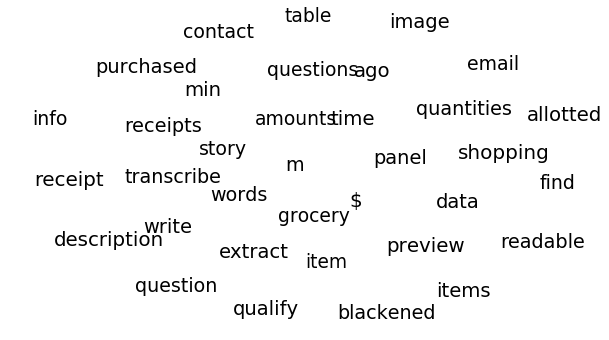

In [85]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

Spectral Embedding

In [101]:
SpectralEmbeddingWords = sklearn.manifold.SpectralEmbedding(n_components = 2).fit_transform(reducedPCA_data)

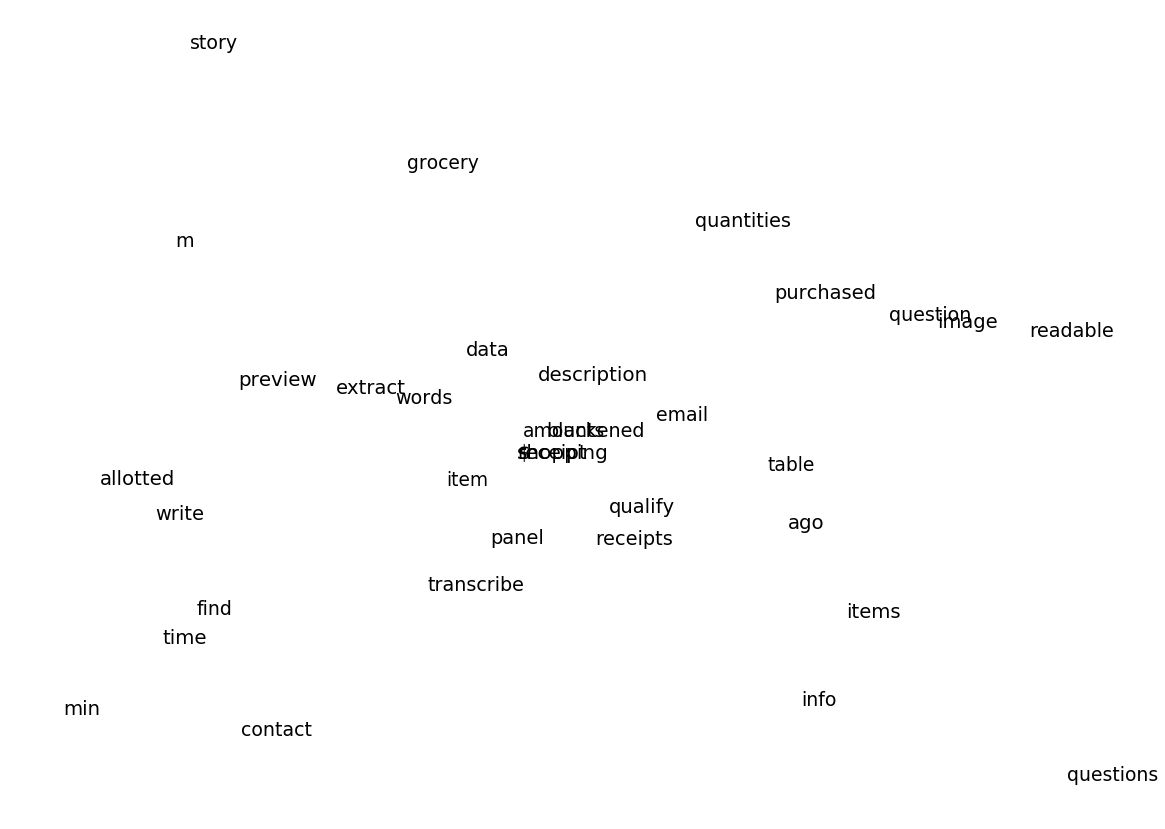

In [105]:
fig = plt.figure(figsize = (20, 15))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(SpectralEmbeddingWords[:, 0], SpectralEmbeddingWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (SpectralEmbeddingWords[:, 0][i],SpectralEmbeddingWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using `doc2vec`, and explore the relationship between different documents and the word vectors you analyzed in the last exercise. Consider the most similar words to critical documents, analogies (doc _x_ + word _y_), and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the documentary organization of your semantic space?

In [53]:
hitsmk1DF = pandas.read_csv( r"C:\Users\acmel\OneDrive - The University of Chicago\SOCI 40133\Octoparse\test2.csv", 
    index_col = 0)
hitsmk1DF[:800:100]

,Title,Reward
Requester,,
Panel,Extract purchased items from a shopping receipt,$0.09
Anders Friis Marstand,A study of leaders (follow-up survey)(~ 3 minu...,$0.80
str11223344,Tell us what this item is - Soft Goods - Batch...,$0.07
MODIFI,Collect data from the 'impressum' section of a...,$0.08
Alexandria Powers,Answer a survey about disability perceptions,$1.05
Mike,"14 Short, Silly Yes/No Questions",$0.10
Phonology and Reading Lab,"Compensation for previous HIT ""How the Mind Wo...",$0.30
Noah Turk,Which Conversational Partner is Better?,$0.50


keywords= verbs and instructions

In [23]:
keywords = ['extract', 'trace', 'create', 'answer', 'seeing', 'clean', 'find',
            'paraphrase', 'write', 'answer', 'label', 'search', 'judge', 
            'tell', 'collect', 'describe', 'talk', 'draw', 'write', 'do', 
            'chat', 'identify', 'evaluate', 'verify', 'rate', 'survey', 
            'upload', 'compare', 'watch', 'record', 'determine', 
            'categorization', 'make', 'provide', 'transcribe', 'help',
           'audit', 'aprender']
keywords

['extract',
 'trace',
 'create',
 'answer',
 'seeing',
 'clean',
 'find',
 'paraphrase',
 'write',
 'answer',
 'label',
 'search',
 'judge',
 'tell',
 'collect',
 'describe',
 'talk',
 'draw',
 'write',
 'do',
 'chat',
 'identify',
 'evaluate',
 'verify',
 'rate',
 'survey',
 'upload',
 'compare',
 'watch',
 'record',
 'determine',
 'categorization',
 'make',
 'provide',
 'transcribe',
 'help',
 'audit',
 'aprender']

In [24]:
hitsmk1DF['tokenized_words'] = hitsmk1DF['Title'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
hitsmk1DF['normalized_words'] = hitsmk1DF['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [25]:
taggedDocs = []
for index, row in hitsmk1DF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['Title'])
  #  docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
hitsmk1DF['TaggedTitle'] = taggedDocs

In [26]:
hitsmk1DF['TaggedTitle'] = taggedDocs

In [27]:
hitsmk1D2V = gensim.models.doc2vec.Doc2Vec(hitsmk1DF['TaggedTitle'])
#, vector_size = 100) #Limiting to 100 dimensions

In [28]:
hitsmk1D2V.docvecs[1]

array([ 9.6535624e-04, -1.1478332e-04,  1.6064256e-03,  2.7235500e-03,
        3.1064681e-03,  3.0732877e-03,  1.8053842e-03,  2.2169629e-03,
       -2.7723680e-03, -2.2522770e-03, -3.1567926e-03,  2.9330275e-03,
        1.3616447e-03, -3.8872976e-03, -3.4540885e-03,  9.6177176e-04,
        4.3247016e-03,  3.7774094e-03,  8.3050586e-04,  3.9004514e-03,
       -1.6233580e-04,  2.2058346e-04,  4.2021759e-03, -3.0902063e-03,
        3.5125676e-03,  1.4555665e-03, -8.9643802e-04, -1.5563359e-03,
        4.3168650e-03,  1.9421637e-03, -1.6330696e-03,  1.2010824e-03,
       -4.4868286e-03, -4.2356993e-03,  5.5517320e-04, -7.5842242e-04,
       -4.1232854e-03,  1.5289991e-03,  3.0441743e-03,  1.2267713e-03,
       -1.0401420e-03,  9.3531143e-04, -1.9787156e-03, -1.4305293e-03,
       -5.1709851e-03, -4.4719118e-04, -2.4681620e-03, -4.3908422e-05,
        1.9133171e-04, -3.1897721e-03,  1.2071019e-03, -2.9970340e-03,
        3.4749161e-03, -1.4021049e-03,  5.1162420e-03,  1.5874511e-03,
      

In [29]:
hitsmk1D2V['collect']

array([-0.00043984,  0.00486426,  0.00150749,  0.00356011, -0.00213916,
        0.00207085, -0.00375704,  0.00207602, -0.0041762 , -0.00480612,
        0.00025326,  0.00532782,  0.00081412, -0.0011062 ,  0.00077496,
        0.00328125,  0.00447441, -0.00051646,  0.00153196, -0.00404656,
       -0.00216541, -0.00322966, -0.0051652 , -0.00149046, -0.00339966,
       -0.00275077,  0.00364747, -0.00209674,  0.00306856,  0.00355097,
       -0.0009639 , -0.0021511 ,  0.00243419, -0.00051857,  0.00448002,
       -0.00439158, -0.00121369,  0.0003547 , -0.00128244,  0.00394997,
        0.00166674, -0.00228248,  0.00101924,  0.00481864,  0.00451703,
        0.00293611,  0.0001846 ,  0.00168136,  0.00232839,  0.00426173,
        0.00053145, -0.00286358,  0.004401  ,  0.00040159,  0.00358996,
       -0.00410698,  0.00372877, -0.00493499,  0.0038866 , -0.00313153,
        0.00208086,  0.0030795 , -0.00281037, -0.00310987,  0.00132869,
       -0.00226176,  0.00267513, -0.00270788,  0.00136152, -0.00

In [30]:
hitsmk1D2V['data']

array([ 3.38813057e-03,  4.52255504e-03, -4.97725094e-03,  5.07391803e-03,
       -3.76158278e-03, -2.65843235e-03,  4.78070928e-03,  2.14834930e-03,
       -4.69759107e-03, -1.75889209e-03,  3.77897522e-04,  4.76846145e-03,
       -1.36489293e-03, -1.05579806e-04,  5.34529705e-03,  4.16927412e-03,
        3.03111132e-03,  3.28324083e-03, -7.33540161e-04,  4.38474771e-03,
        1.98400859e-03,  2.49165716e-03,  2.03528849e-04,  2.78336159e-03,
        9.98648466e-04,  2.57795397e-03, -2.30028457e-03,  2.89892009e-03,
       -1.83129287e-03, -1.97189208e-03,  4.21997905e-03, -4.00232757e-03,
       -5.17448829e-03, -2.30147899e-03, -3.55713279e-03, -3.02681653e-03,
       -1.37710210e-03,  4.70768660e-03, -4.00363002e-03,  1.36085716e-03,
        9.27037327e-04, -6.01659063e-04, -8.88951123e-04, -4.27037524e-03,
        1.33764686e-03,  2.07808171e-03,  5.32378210e-03, -1.30340608e-03,
       -2.50774436e-03, -4.44617122e-03, -6.99496595e-04,  2.34556687e-03,
       -1.17219612e-03, -

In [31]:
hitsmk1D2V['extract']

array([ 1.42965582e-03,  1.07485126e-03, -1.63541595e-03,  4.92576556e-03,
       -3.86356446e-03,  7.00628338e-03, -3.41193285e-03, -8.19816813e-03,
       -9.47608030e-04,  1.10057066e-03, -4.85773664e-03,  7.52270082e-03,
        5.85473841e-03,  1.05475052e-03,  6.97770563e-04, -7.35560607e-04,
       -3.61169083e-03,  3.30791180e-03,  1.05433143e-03,  3.77662457e-03,
       -2.02681683e-03,  5.62280370e-03, -2.47345888e-03,  4.47456585e-03,
       -1.55672536e-03,  1.74704427e-03, -4.84281406e-03, -4.28501237e-03,
       -5.86975506e-03, -7.77785107e-03,  4.15665563e-03,  4.94090564e-05,
       -6.55066548e-03,  3.80720652e-04,  8.21317546e-04,  2.06498938e-04,
       -2.43161619e-03, -2.67777801e-03,  2.25585862e-03, -3.17321904e-03,
        2.01889849e-03,  2.37170164e-03, -3.34176049e-03,  6.84419123e-04,
        2.33407511e-04,  1.14698953e-03,  4.75068204e-03, -4.85767983e-03,
       -3.57786962e-03, -2.63641775e-03, -1.11099435e-02,  2.29624566e-03,
       -4.06468334e-03,  

In [32]:
hitsmk1D2V.most_similar(positive = ['collect','data'], negative = ['extract'], topn = 1)

[('preferences', 0.14929385483264923)]

In [33]:
hitsmk1D2V['personal']

array([ 3.8053545e-03,  1.1307502e-03,  2.9377164e-03,  5.8965804e-03,
       -4.7387071e-03,  1.8280892e-03, -3.6129500e-03, -6.0719238e-03,
       -8.0636935e-04, -3.8846189e-03, -1.6138332e-03,  2.1193677e-03,
        5.4399152e-03, -4.2748847e-03,  7.0793144e-03, -4.3287273e-03,
        2.4585638e-03,  3.3619220e-03, -3.2237766e-03,  4.6415078e-03,
        2.4005938e-04,  3.5927810e-03, -1.9392407e-03, -3.3610705e-03,
        2.0243365e-03,  2.7990777e-03,  6.6082698e-04,  2.8488564e-03,
       -5.9335069e-03,  9.3540916e-04,  3.2637009e-04,  1.6409531e-03,
        3.8649279e-04, -1.1457982e-03,  6.0563453e-04, -4.8051621e-03,
        3.2485162e-03, -1.6662700e-03, -4.2307302e-03,  4.2458498e-03,
        5.1721060e-03,  3.3891820e-03, -3.1105285e-03,  1.5345307e-03,
        3.5835300e-03, -5.0399867e-03, -7.5455831e-04,  3.7334275e-03,
       -5.7175700e-03, -2.0007514e-03, -3.3171542e-03, -1.4004976e-03,
        1.8131275e-03,  5.6116693e-03, -2.5043904e-03, -3.0320950e-04,
      

This is another interesting result, implying that "collect" is to "data" as "extract" is to "persona" -- presumabkly, "personal" information of some sort.  To extent that HITs which request that the Worker collect something are connected to data objects, HITs which request that the Worker extract something are connected in the same way to personal information.   

From this, we can hypothesize that HITs similarly structure cognitive labor involving both the investigation of individuals' personal information and the gathering of generic information from other sources.

In this, we can see an example of the alienation which digital crowdlabor platforms inflict on individuals by computationally commodifying information.    

HeatMap plots

In [34]:
keywords = ['extract', 'trace', 'create', 'answer', 'seeing', 'clean', 'find',
            'paraphrase', 'write', 'answer', 'label', 'search', 'judge', 
            'tell', 'collect', 'describe', 'talk', 'draw', 'write', 
            'chat', 'identify', 'evaluate', 'verify', 'rate', 'survey', 
            'upload', 'compare', 'watch', 'record', 'determine', 
            'categorization', 'provide', 'transcribe', 'help',
           'audit', 'aprender']

In [35]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = hitsmk1D2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity
                      (tagVec, hitsmk1D2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

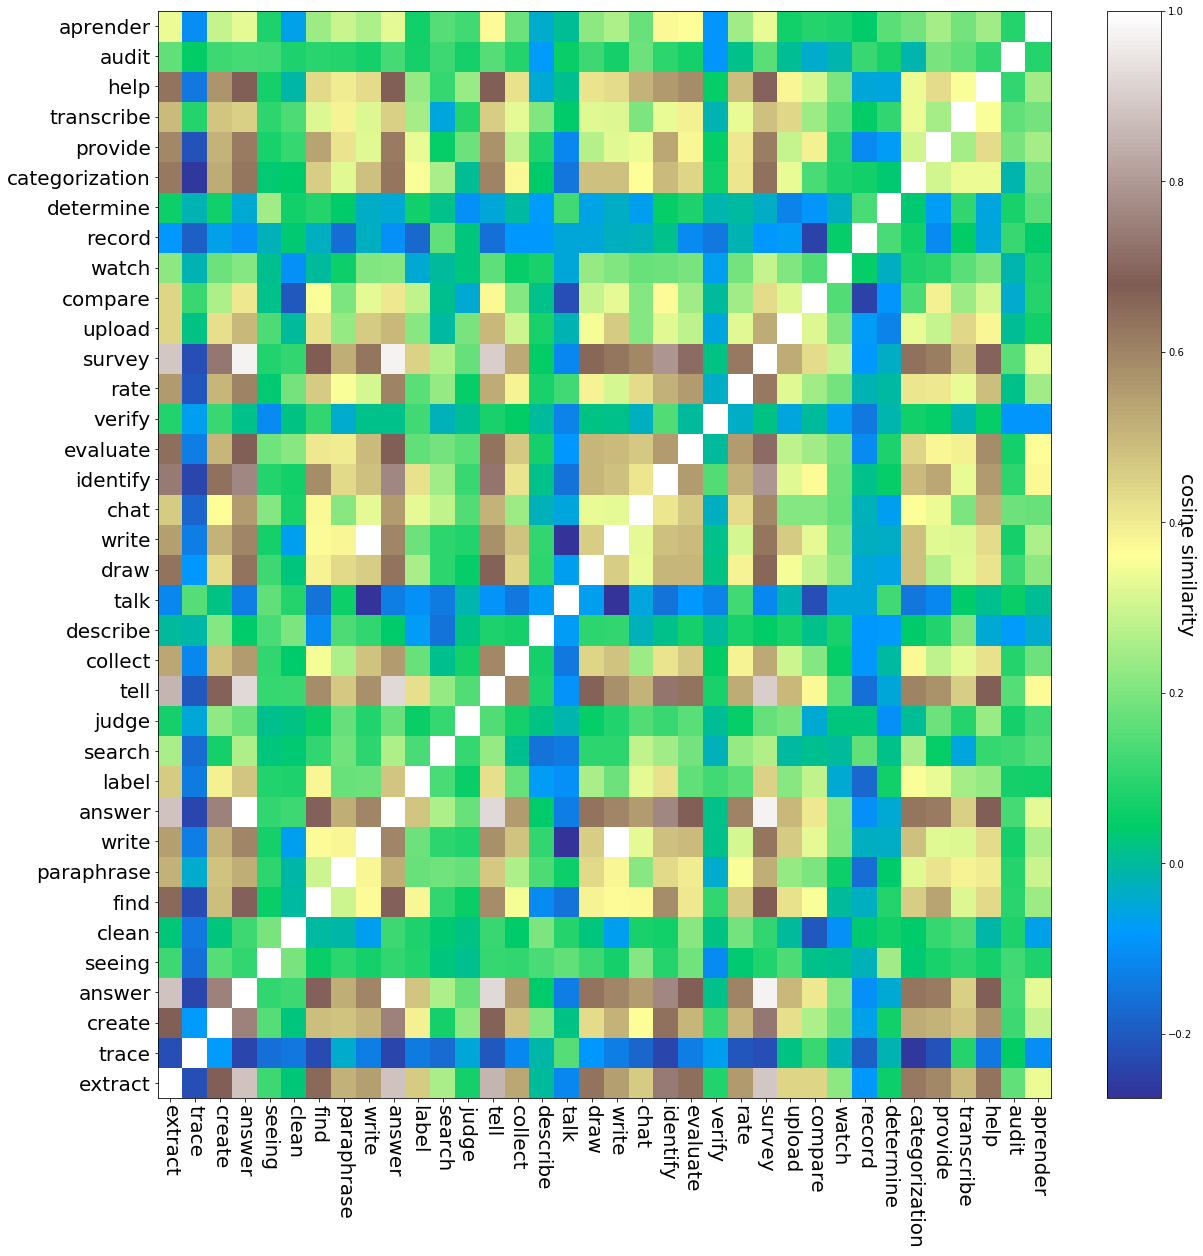

In [36]:
fig, ax = plt.subplots(figsize=(20,20))
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270, size=20)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270, size=20)
a = ax.set_yticklabels(keywords, minor=False, size=20)

Predictably, the terms "answer" and "tell" are very closely associated with "survey".  More interestingly, "extract" is also associated with both "survey" and "answer".  Building on the previous hypothesis about the relation between "extract" instructions and "personal (data)" we can infer that the primary means of extracting personal data is through surveys issued to mTurk Workers.  This then implies that the personal data being extracted is that of the Workers themselves, further supporting the theory that the Workers are the primary subjects of computationa alienation via crowdsourced data commodification.  


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project, then generate meaningful semantic dimensions based on your theoretical understanding of the semantic space (i.e., by subtracting semantically opposite word vectors) and project another set of word vectors onto those dimensions. Interpret the meaning of these projections for your analysis. Which of the dimensions you analyze explain the most variation in the projection of your words and why? 

<span style="color:red">***Stretch***: Average together multiple antonym pairs to create robust semantic dimensions. How do word projections on these robust dimensions differ from single-pair dimensions?

In [128]:
#Apply our functions, notice each row is a list of lists now
hitsmk1DF['tokenized_sents'] = hitsmk1DF['Title'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
hitsmk1DF['normalized_sents'] = hitsmk1DF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])

hitsmk1DF[:100:10]

,Title,Reward,tokenized_sents,normalized_sents
Requester,,,,
Panel,Extract purchased items from a shopping receipt,0.09,"[[Extract, purchased, items, from, a, shopping...","[[extract, purchased, items, shopping, receipt]]"
celinachan610,Paraphrase machine-generated questions,0.10,"[[Paraphrase, machine, generated, questions]]","[[paraphrase, machine, generated, questions]]"
Job Spotter,Extract contact information from a hiring sign,0.03,"[[Extract, contact, information, from, a, hiri...","[[extract, contact, information, hiring, sign]]"
xlab research,Write captions about photoshopped images,1.50,"[[Write, captions, about, photoshopped, images]]","[[write, captions, photoshopped, images]]"
str11223344,Tell us what this item is - General Contents -...,0.07,"[[Tell, us, what, this, item, is, General, Con...","[[tell, item, general, contents, batch, d]]"
Maarten Sap,Rate the quality of short stories,0.27,"[[Rate, the, quality, of, short, stories]]","[[rate, quality, short, stories]]"
Pinterest,Pinterest - Determine the topical relatedness ...,0.60,"[[Pinterest, Determine, the, topical, relatedn...","[[pinterest, determine, topical, relatedness, ..."
Panel,Extract purchased items from a shopping receip...,0.04,"[[Extract, purchased, items, from, a, shopping...","[[extract, purchased, items, shopping, receipt..."
David Markowitz,Tell us about your experiences in media planni...,0.50,"[[Tell, us, about, your, experiences, in, medi...","[[tell, experiences, media, planning!(~, minut..."


In [129]:
hitsmk1W2V = gensim.models.word2vec.Word2Vec(hitsmk1DF['normalized_sents'].sum())

In [137]:
hitsmk1W2V.wv.syn0
hitsmk1W2V.wv.index2word

['minutes',
 'survey',
 'batch',
 'd',
 'tell',
 'item',
 'compensation',
 'hit(~',
 'hit',
 'answer',
 'extract',
 'health',
 'data',
 'shopping',
 'ages',
 'mental',
 'receipt',
 'items',
 'veterans',
 '65)(~',
 'general',
 'contents',
 'study',
 '$',
 'chat',
 'evaluate',
 'bot',
 'soft',
 'goods',
 '~',
 'short',
 'purchased',
 'task',
 'question',
 'find',
 'image',
 'information',
 'website',
 'questions',
 'minute',
 'images',
 'bonus',
 'cost',
 'replace',
 'summary',
 'text',
 'collect',
 'electronics',
 'better',
 'identify',
 'bounding',
 'draw',
 'business',
 'game',
 'brands',
 'ads',
 'complete',
 'featured',
 'banner',
 'article',
 'transcribe',
 'group',
 'experiences',
 'follow',
 'opinions',
 'audio',
 'training',
 'research',
 'company',
 '|',
 'quality',
 'receipts',
 'consumer',
 'cognition',
 'memory',
 'create',
 'contain',
 'write',
 'boxes',
 'topics',
 'answering',
 'rate',
 'test',
 'earn',
 'academic',
 'utterance',
 'time',
 'recording',
 'upload',
 'de',
 

In [138]:
pcaWords = sklearn.decomposition.PCA(n_components = 10).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

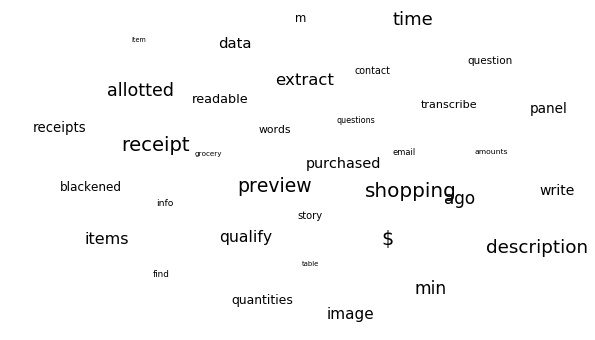

In [139]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

In [140]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [141]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

In [142]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

In [143]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

In [144]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

In [145]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

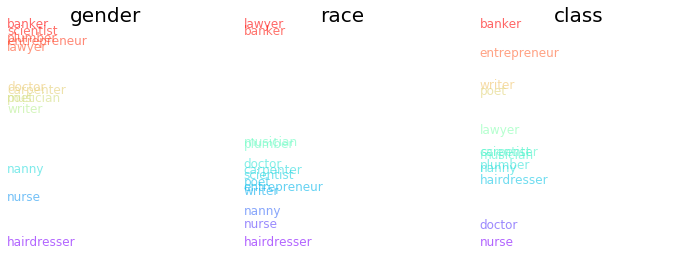

In [146]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

You would increase the sample size if you want to do a more serious study.

## <span style="color:red">*Exercise 4a*</span>

<span style="color:red">**Do only 4a or 4b.** Construct cells immediately below this that calculate the scores for a small sample of documents from outside your corpus to identify which are *closest* to your corpus. Then calculate the scores for a few phrases or sentences to identify the ones most likely to have appeared in your corpus. Interrogate patterns associated with these document/phrase scores (e.g., which companies produced job ads most or least likely to find jobseekers in the resume corpus?) What do these patterns suggest about the boundaries of your corpus?

In [147]:
hitsmk1DF['Reward'] = hitsmk1DF['Reward'].map(lambda x: x.lstrip('$'))
hitsmk1DF

,Title,Reward,tokenized_sents,normalized_sents
Requester,,,,
Panel,Extract purchased items from a shopping receipt,0.09,"[[Extract, purchased, items, from, a, shopping...","[[extract, purchased, items, shopping, receipt]]"
Computer Vision Turk,Trace Object Boundaries,0.60,"[[Trace, Object, Boundaries]]","[[trace, object, boundaries]]"
Phil Maher,"""Archival Video Reviewer"" Create Title Descrip...",0.01,"[[Archival, Video, Reviewer, Create, Title, De...","[[archival, video, reviewer, create, title, de..."
James Billings,Market Research Survey,0.01,"[[Market, Research, Survey]]","[[market, research, survey]]"
Panel,Extract purchased items from a shopping receipt,0.08,"[[Extract, purchased, items, from, a, shopping...","[[extract, purchased, items, shopping, receipt]]"
Bright--Side,How do you feel when seeing a painting?(WARNIN...,0.07,"[[How, do, you, feel, when, seeing, a, paintin...","[[feel, seeing, painting?(warning, hit, contai..."
Content Research,Clean Up How-To Questions,0.05,"[[Clean, Up, How, To, Questions]]","[[clean, questions]]"
LE METAYER Baptiste,Find data about company,0.03,"[[Find, data, about, company]]","[[find, data, company]]"
Lei Hou,Paraphrase machine-generated questions,0.10,"[[Paraphrase, machine, generated, questions]]","[[paraphrase, machine, generated, questions]]"


In [148]:
hitsmk1DF.sort_values(by = 'Reward', ascending=False)[:50]


,Title,Reward,tokenized_sents,normalized_sents
Requester,,,,
SurveyComet,Survey - webcam & audio recording required(~ 2...,8.00,"[[Survey, webcam, audio, recording, required(~...","[[survey, webcam, audio, recording, required(~..."
SurveyComet,Survey - webcam & audio recording required(~ 2...,8.00,"[[Survey, webcam, audio, recording, required(~...","[[survey, webcam, audio, recording, required(~..."
Olivier Klein,HIT for A1U5BE8XJRXKW3,8.00,"[[HIT, for, A1U5BE8XJRXKW3]]","[[hit, a1u5be8xjrxkw3]]"
SurveyComet,Survey - webcam & audio recording required(~ 2...,8.00,"[[Survey, webcam, audio, recording, required(~...","[[survey, webcam, audio, recording, required(~..."
SurveyComet,Survey - webcam & audio recording required(~ 2...,8.00,"[[Survey, webcam, audio, recording, required(~...","[[survey, webcam, audio, recording, required(~..."
SurveyComet,Survey - webcam & audio recording required(~ 2...,8.00,"[[Survey, webcam, audio, recording, required(~...","[[survey, webcam, audio, recording, required(~..."
Olivier Klein,HIT for A1U3UUELW55W65,8.00,"[[HIT, for, A1U3UUELW55W65]]","[[hit, a1u3uuelw55w65]]"
SurveyComet,Survey - webcam & audio recording required(~ 2...,8.00,"[[Survey, webcam, audio, recording, required(~...","[[survey, webcam, audio, recording, required(~..."
Empirical Jury,Compensation HIT(~ 1 minutes),6.75,"[[Compensation, HIT(~, 1, minutes]]","[[compensation, hit(~, minutes]]"


From these results we can see that many of the highest-paying HITs are surveys.  This is significant given the role of survey HITs in the aforementioned hypothesis on personal data extraction.  It reveals that suryeys targeting Workers for their personal data are highly valuable sources of information for Requesters.

## <span style="color:red">*Exercise 4b*</span>

<span style="color:red">**Do only 4a or 4b.** Construct cells immediately below this that align word embeddings over time or across domains/corpora. Interrogate the spaces that result and ask which words changed most and least over the entire period or between contexts/corpora. What does this reveal about the social game underlying your space? 